# Module import

In [1]:
from selenium import webdriver as wd
from selenium.webdriver.support.ui import Select
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns


#오류구문
import warnings
warnings.filterwarnings(action='ignore')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import matplotlib.font_manager as fm 
import matplotlib.pyplot as plt
from matplotlib import rc
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rcParams['font.family'] = font_name

import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Crawling code

In [3]:
# 경기정보 크롤링
driver = wd.Chrome(executable_path="chromedriver.exe")
url = "https://www.koreabaseball.com/Schedule/Calendar.aspx"

driver.get(url)

#9월달 테이블 확인
dropdown = Select(driver.find_element_by_xpath("//*[@id='ddlMonth']"))
dropdown.select_by_value("09")

#테이블 가져오기
table = driver.find_element_by_class_name('schedulCalender')
tbody = table.find_element_by_tag_name("tbody")
rows = tbody.find_elements_by_tag_name("tr")

#매치 정보 임시리스트
val = []

for i, value in enumerate(rows):
#     if i == 0: # th분리
#         continue
    td = value.find_elements_by_tag_name("td")
    
    for i, value in enumerate(td):
        if len(value.text) <= 2: # str데이터로 매치가 없거나 날짜만 있는 경우
            continue
            
        oneday = value.text.split('\n')
#         print(oneday)
        
        for j in range(len(oneday)):
            if j == 0 or '[' in oneday[j]: # 경기결과를 알수 없는 경우(취소로 추정)
                continue
            
            match = [oneday[0]] + oneday[j].split(' ')
            del match[3]
#             print(match)
            val.append(match)
        

driver.quit()

In [4]:
val[0:5]

[['1', '롯데', '1', '2', '두산'],
 ['1', 'NC', '3', '2', 'SSG'],
 ['1', 'LG', '3', '1', 'KT'],
 ['1', '삼성', '4', '1', 'KIA'],
 ['1', '한화', '1', '7', '키움']]

In [5]:
# 매치에 승패정보 추가

for ele in val:
    if ele[2] > ele[3]:
        ele.append("A") # team A win
    elif ele[2] < ele[3]:
        ele.append("B") # team B win
    else:
        ele.append("D") # draw
        
val[0:5]

[['1', '롯데', '1', '2', '두산', 'B'],
 ['1', 'NC', '3', '2', 'SSG', 'A'],
 ['1', 'LG', '3', '1', 'KT', 'A'],
 ['1', '삼성', '4', '1', 'KIA', 'A'],
 ['1', '한화', '1', '7', '키움', 'B']]

In [6]:
df_match = pd.DataFrame(val, columns = ["day", "teamA", "Ateam score", "Bteam score", "teamB", "result"])
df_match['month'] = '9'
# df_match.head()

In [7]:
df_match['node'] = df_match['month'] + '-' + df_match['day'] + '_' + df_match['teamA'] + '_' + df_match['teamB']
df_match.head()

,day,teamA,Ateam score,Bteam score,teamB,result,month,node
0,1,롯데,1,2,두산,B,9,9-1_롯데_두산
1,1,NC,3,2,SSG,A,9,9-1_NC_SSG
2,1,LG,3,1,KT,A,9,9-1_LG_KT
3,1,삼성,4,1,KIA,A,9,9-1_삼성_KIA
4,1,한화,1,7,키움,B,9,9-1_한화_키움


In [8]:
# 팀 정보 크롤링
url_team = "https://www.koreabaseball.com/Record/Team/Hitter/Basic1.aspx"
driver = wd.Chrome(executable_path="chromedriver.exe")

driver.get(url_team)

#테이블 가져오기
div = driver.find_element_by_class_name('record_result')
table = div.find_element_by_tag_name("table")
tbody = table.find_element_by_tag_name("tbody")
rows = tbody.find_elements_by_tag_name("tr")

title = table.find_element_by_tag_name("thead")
columns_raw = title.find_elements_by_tag_name("th")
col = []

for value in columns_raw:
#     print(value.text)
    col.append(value.text)
# print(col)

team_info = []

for value in rows:
    td = value.find_elements_by_tag_name("td")
    oneteam = []
    
    for ele in td:
#         print(ele.text)
        oneteam.append(ele.text)
    
    team_info.append(oneteam)

# print(team_info)
driver.quit()

In [9]:
df_team = pd.DataFrame(team_info, columns=col)
# df_team.head()

# Convert data to graph elements

In [10]:
def add_edges(df, digraph):
    for i, row in df.iterrows():
        if row['result'] == 'A':
            digraph.add_edge(row['node'], row['teamB'])
            digraph.add_edge(row['teamA'], row['node'])
        elif row['result'] == 'B':
            digraph.add_edge(row['node'], row['teamA'])
            digraph.add_edge(row['teamB'], row['node'])

def calculate_directed_degree_centrality(digraph, df_teams):
    centrality = {}
    for name in df_teams['팀명']:
        cen_val = digraph.out_degree[name] / (len(digraph.nodes) - 1)
        centrality[name] = cen_val
    return centrality
            
def seperate_nodes(graph):
    teams = []
    mat = []
    for node, deg in nx.degree(graph):
        if deg >= 3:
            teams.append(node)
        else:
            mat.append(node)
    team_nodes = graph.subgraph(teams)
    match_nodes = graph.subgraph(mat)
    return team_nodes, match_nodes
            
def draw_cengrality(graph, centrality):
    team_nodes, match_nodes = seperate_nodes(graph)
    values = centrality.values()
    nodes_order = {team:0 for team in team_nodes}
    for key in centrality:
        nodes_order[key] = centrality[key]
    
    norm = Normalize(vmin=min(values), vmax=max(values))
    node_color = [cm.viridis(norm(c)) for name, c in nodes_order.items()]
    pos = nx.spring_layout(graph, k=0.2)
    plt.rcParams['figure.figsize'] = (12, 10)

    nx.draw_networkx_nodes(team_nodes, pos=pos, node_size=2000, node_color=node_color) 
    nx.draw_networkx_labels(team_nodes, pos=pos, font_size=15, font_color='black', font_family=font_name)
    
    nx.draw_networkx_nodes(match_nodes, pos=pos, node_size=300, node_color='grey')
    nx.draw_networkx_labels(match_nodes, pos=pos, font_size=8, font_color='black', font_family=font_name)
    
    nx.draw_networkx_edges(graph, pos=pos, edge_color='lightgrey')
    
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'))
    plt.show()

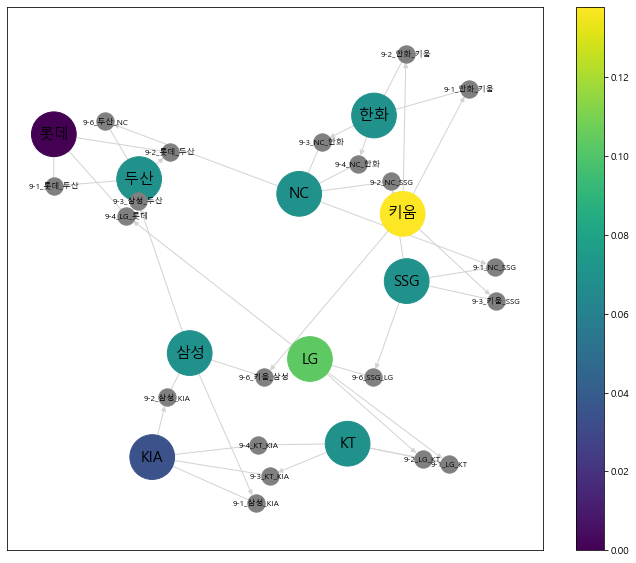

In [11]:
# 방향 그래프
graph = nx.DiGraph()

# 팀노드
graph.add_nodes_from(df_team['팀명'])

# 매치 노드(20개)
graph.add_nodes_from(df_match.loc[0:19, :]['node'])
add_edges(df_match.loc[0:19, :], graph)



# nx.draw(graph, with_labels = True, font_weigth = "bold", font_family = font_name)
draw_cengrality(graph, calculate_directed_degree_centrality(graph, df_team))

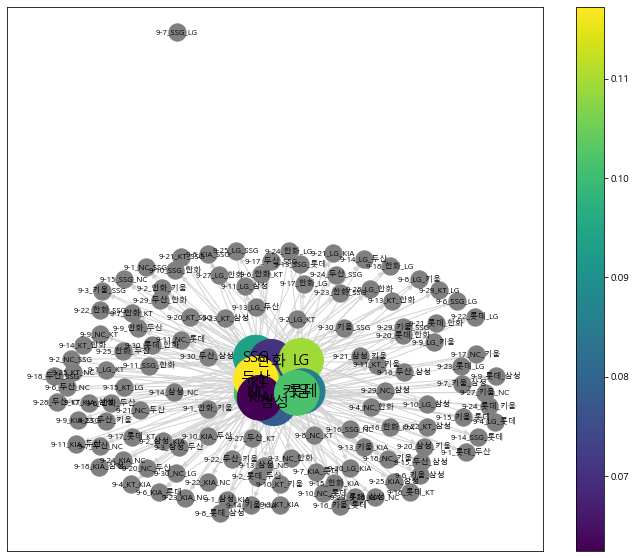

In [12]:
# 방향 그래프
graph_all = nx.DiGraph()

# 팀노드
graph_all.add_nodes_from(df_team['팀명'])

# 매치 노드(20개)
graph_all.add_nodes_from(df_match['node'])
add_edges(df_match, graph_all)


draw_cengrality(graph_all, calculate_directed_degree_centrality(graph_all, df_team))

In [13]:
def visualize_corr(df):
    plt.figure(figsize=(5, 5))

    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(data=df.corr(),
                cmap='RdYlBu_r',
                mask=mask,
                annot=True, fmt='.2f',
                linewidth=.5)
    plt.show()

In [14]:
def match_statistic(df_matchs):
    win_list = []
    all_list = []

    team_perform = []

    for i, row in df_matchs.iterrows():
        all_list.append(row['teamA'])
        all_list.append(row['teamB'])
        if row['result'] == 'A':
            win_list.append(row['teamA'])
        elif row['result'] == 'B':
            win_list.append(row['teamB'])

    win_list
    names = df_team['팀명'].to_list()

    for ele in names:
        temp = []
        temp.append(ele)
        temp.append(win_list.count(ele))
        temp.append(all_list.count(ele))
        team_perform.append(temp)
    return team_perform
    
def teams_centrality(centrality, df_teams):
    result = {}
    for name in df_teams['팀명']:
        cen_val = centrality[name]
        result[name] = cen_val
    return result

mat_result = pd.DataFrame(match_statistic(df_match.loc[0:19, :]), columns=['팀명', '승수', '경기수'])
mat_result['out_degree'] = calculate_directed_degree_centrality(graph, df_team).values()
mat_result['betweenness'] = teams_centrality(nx.betweenness_centrality(graph), df_team).values()
mat_result['closeness'] = teams_centrality(nx.closeness_centrality(graph), df_team).values()
mat_result.sort_values('승수', ascending=False).reset_index(drop=True)

,팀명,승수,경기수,out_degree,betweenness,closeness
0,키움,4,4,0.137931,0.000000,0.000000
1,LG,3,4,0.103448,0.165435,0.095491
2,삼성,2,4,0.068966,0.115353,0.112011
3,NC,2,5,0.068966,0.173645,0.149925
4,두산,2,4,0.068966,0.085796,0.197722
5,KT,2,4,0.068966,0.140394,0.096983
6,SSG,2,4,0.068966,0.182184,0.118906
7,한화,2,4,0.068966,0.064532,0.077586
8,KIA,1,4,0.034483,0.128079,0.140249
9,롯데,0,3,0.000000,0.000000,0.204225


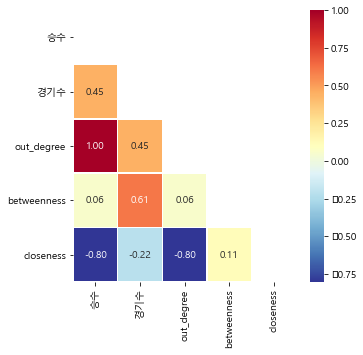

In [15]:
visualize_corr(mat_result)

<b>경기의 표본이 적어 정확한 판단 불가</b>

In [16]:
mat_result_all = pd.DataFrame(match_statistic(df_match), columns=['팀명', '승수', '경기수'])
mat_result_all['out_degree'] = calculate_directed_degree_centrality(graph_all, df_team).values()
mat_result_all['betweenness'] = teams_centrality(nx.betweenness_centrality(graph_all), df_team).values()
mat_result_all['closeness'] = teams_centrality(nx.closeness_centrality(graph_all), df_team).values()
mat_result_all.sort_values('승수', ascending=False).reset_index(drop=True)

,팀명,승수,경기수,out_degree,betweenness,closeness
0,두산,15,25,0.117188,0.203620,0.335127
1,LG,14,24,0.109375,0.192397,0.329863
2,NC,13,26,0.101562,0.224727,0.342413
3,KT,13,23,0.101562,0.182724,0.310364
4,키움,13,23,0.101562,0.181120,0.300019
5,SSG,12,23,0.093750,0.179214,0.331600
6,롯데,11,22,0.085938,0.174736,0.326445
7,삼성,10,23,0.078125,0.181828,0.311901
8,한화,9,26,0.070312,0.198058,0.295793
9,KIA,8,23,0.062500,0.184441,0.368444


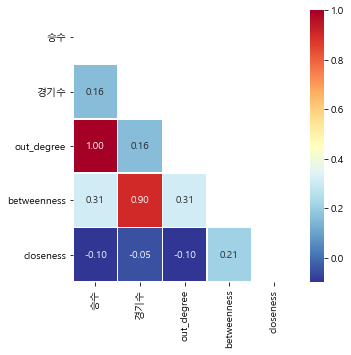

In [17]:
visualize_corr(mat_result_all)

## Analysis

### 1. Centrality
1) Out degree centrality<br>
 - 승수 / (전체 노드수 - 1)
 - 직접 연결된 승리한 경기의 수에 따라 값이 증가하기 때문에, 승수와의 상관관계가 일치함
 - 두 팀간의 경기에서만 관계를 포함(ex. A팀이 B팀을 이기고, B팀이 C팀을 이겼을 때, A팀이 C팀과의 경기를 했을 때의 상황은 두 팀이직접 경기하지 않고서는 확인 불가)
 - 가장 직관적이고 간단한 분석 수행 가능
<br><br>

2) Betweenness centrality<br>
 - 다른 노드와의 최단거리 사이에 위치하는 정도를 나타냄
 - 노드가 단방향일 경우 값 x
 - 경기 수가 많은 노드, 혹은 그런 노드와 많이 이어진 경우에 값이 높은 경향을 보임
 - 가중치를 이용한 undirected graph를 구현하였을 때, 어떠한 결과가 나올지 분석
<br><br>

3) Closeness centrality<br>
 - 다른 모든 노드와의 최단 경로의 총합과 전체 경로의 비
 - 다른 노드까지의 경로가 존재하는지의 여부가 중요하게 작용하므로, 방향 그래프에서는 단방향 엣지가 많은 노드에서 민감
 - directed graph에 가중치를 부여하였을 때, 어떠한 결과가 나올지 분석
 
<br>

### 2. 향후 계획
1) 추가적인 centrality 측정 방법 조사
 - 경기 결과와 경기 사이의 엣지는 승패 결과를 포함하기 때문에, 가중치 혹은 방향의 포함이 불가피함
 - 가중치 및 방향을 포함할 수 있는 중심성 측정 방안 조사
<br><br>

2) 가중치 부여방법 조사
 - 그래프에서 유의미한 결과를 얻어낼 수 있는 가중치 탐색
 - 프로야구의 통계적 분석을 진행했던 이전의 연구들을 바탕으로 경기의 승리에 영향을 줄 수 있는 가중치 탐색